<a href="https://colab.research.google.com/github/Tamaghnatech/calorie_expenditure/blob/main/Calorie_Expenditure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_sub = pd.read_csv("sample_submission.csv")

print(train.shape, test.shape)
print(train.columns)

train.head()


(444496, 9) (250000, 8)
Index(['id', 'Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate',
       'Body_Temp', 'Calories'],
      dtype='object')


,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [3]:

train = pd.get_dummies(train, drop_first=True)
test = pd.get_dummies(test, drop_first=True)

# Align columns in case some categories are missing in test
train, test = train.align(test, join='left', axis=1, fill_value=0)


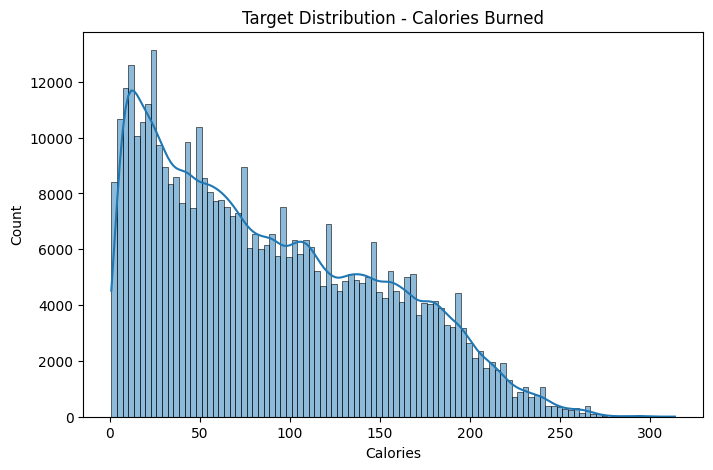

<Axes: >

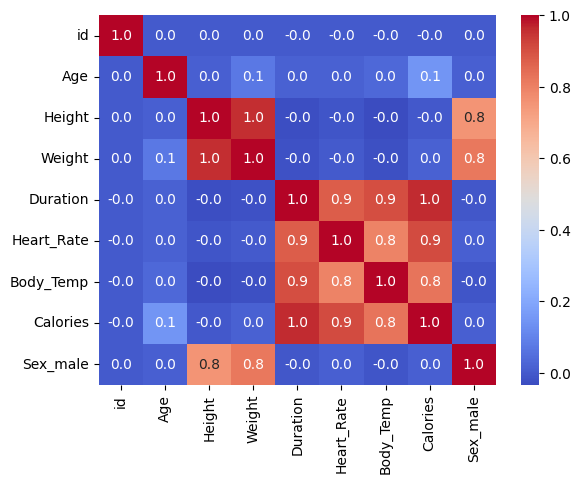

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(train['Calories'], kde=True, bins=100)
plt.title('Target Distribution - Calories Burned')
plt.show()

sns.heatmap(train.corr(), annot=True, fmt=".1f", cmap="coolwarm")


In [12]:
!pip install -U lightgbm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 30.5 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.5.0
    Uninstalling lightgbm-4.5.0:
      Successfully uninstalled lightgbm-4.5.0


In [16]:
from sklearn.metrics import mean_squared_log_error
import numpy as np

# Drop NaNs in y_val before using it
mask = ~np.isnan(y_val)
y_val_clean = y_val[mask]
X_val_clean = X_val[mask]
lgb_val_preds = lgb_model.predict(X_val_clean)

# RMSLE calculation
rmsle_lgb = np.sqrt(mean_squared_log_error(y_val_clean, lgb_val_preds))
print(f'LightGBM RMSLE (log scale): {rmsle_lgb:.5f}')


LightGBM RMSLE (log scale): 0.01728


In [18]:
# Ensure X_test has same columns as X used in training
X_test_aligned = X_test[X.columns]

# Now predict
test_preds = lgb_model.predict(X_test_aligned)
final_preds = np.expm1(test_preds)

# Create submission file
submission = pd.DataFrame({
    'id': test['id'],
    'Calories': final_preds
})

submission.to_csv('submission.csv', index=False)

from google.colab import files
files.download('submission.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
# Recompute derived features
train['BMI'] = train['Weight'] / (train['Height'] / 100)**2
test['BMI'] = test['Weight'] / (test['Height'] / 100)**2

train['HR_per_min'] = train['Heart_Rate'] / train['Duration'].replace(0, 0.1)
test['HR_per_min'] = test['Heart_Rate'] / test['Duration'].replace(0, 0.1)

train['Temp_per_min'] = train['Body_Temp'] / train['Duration'].replace(0, 0.1)
test['Temp_per_min'] = test['Body_Temp'] / test['Duration'].replace(0, 0.1)

# New Interaction features
train['HRxTemp'] = train['Heart_Rate'] * train['Body_Temp']
test['HRxTemp'] = test['Heart_Rate'] * test['Body_Temp']

train['Duration_Weight'] = train['Duration'] * train['Weight']
test['Duration_Weight'] = test['Duration'] * test['Weight']


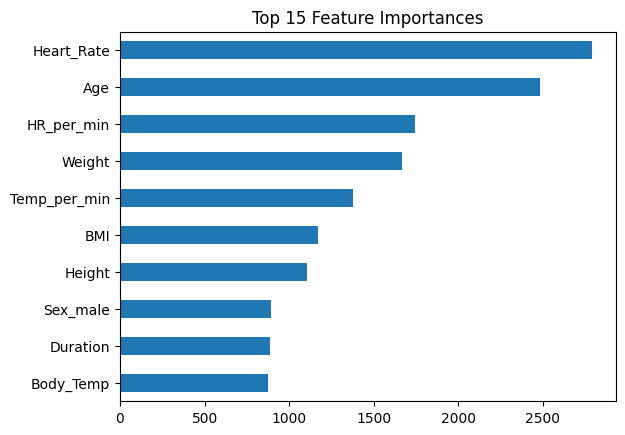

In [20]:
import matplotlib.pyplot as plt

feat_imp = pd.Series(lgb_model.feature_importances_, index=X.columns)
feat_imp.nlargest(15).plot(kind='barh')
plt.title("Top 15 Feature Importances")
plt.gca().invert_yaxis()
plt.show()


In [21]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor

# Base model
lgb_base = LGBMRegressor(objective='regression', random_state=42, n_jobs=-1)

# Hyperparameter grid (light version)
param_dist = {
    'n_estimators': [200, 500, 800],
    'learning_rate': [0.01, 0.03, 0.05, 0.07],
    'num_leaves': [15, 31, 63],
    'max_depth': [3, 5, 7, 9],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

# Setup randomized search
random_search = RandomizedSearchCV(
    lgb_base,
    param_distributions=param_dist,
    n_iter=25,  # feel free to increase if you have time
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42
)

# Run the search
random_search.fit(X_train, y_train)

# Best model & score
print("Best Params:", random_search.best_params_)
print("Best Score (neg RMSE on log-scale):", random_search.best_score_)


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [23]:
best_lgb_model = random_search.best_estimator_


In [24]:
# Predict on test set
X_test_aligned = X_test[X.columns]  # ensure same column structure
test_preds_tuned = best_lgb_model.predict(X_test_aligned)

# Inverse log-transform
final_preds_tuned = np.expm1(test_preds_tuned)

# Submission dataframe
submission_tuned = pd.DataFrame({
    'id': test['id'],
    'Calories': final_preds_tuned
})

submission_tuned.to_csv('submission_tuned_lgb.csv', index=False)

from google.colab import files
files.download('submission_tuned_lgb.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

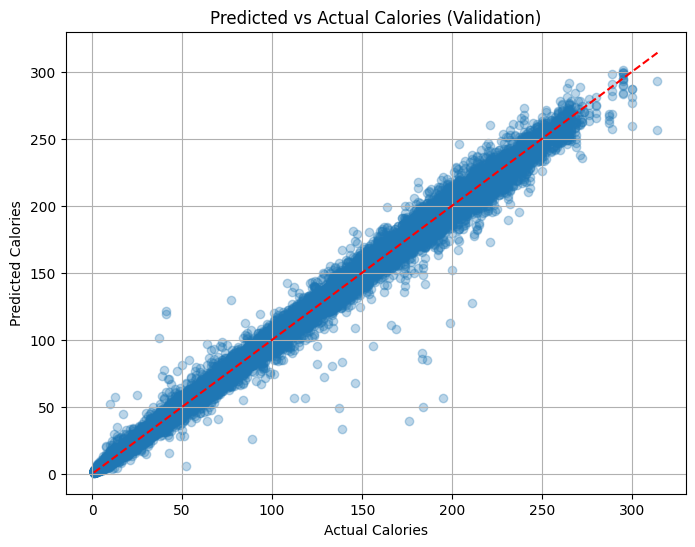

In [25]:
import matplotlib.pyplot as plt

# Predict on validation using best model
val_preds = best_lgb_model.predict(X_val)
val_preds_real = np.expm1(val_preds)
y_val_real = np.expm1(y_val)

plt.figure(figsize=(8, 6))
plt.scatter(y_val_real, val_preds_real, alpha=0.3)
plt.plot([y_val_real.min(), y_val_real.max()], [y_val_real.min(), y_val_real.max()], color='red', linestyle='--')
plt.xlabel('Actual Calories')
plt.ylabel('Predicted Calories')
plt.title('Predicted vs Actual Calories (Validation)')
plt.grid(True)
plt.show()


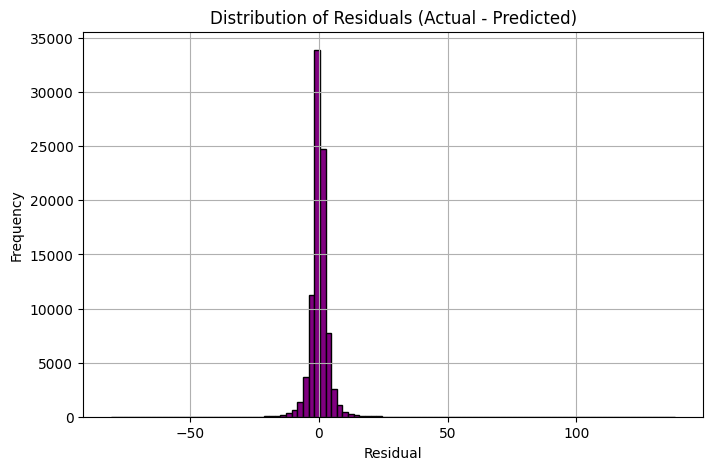

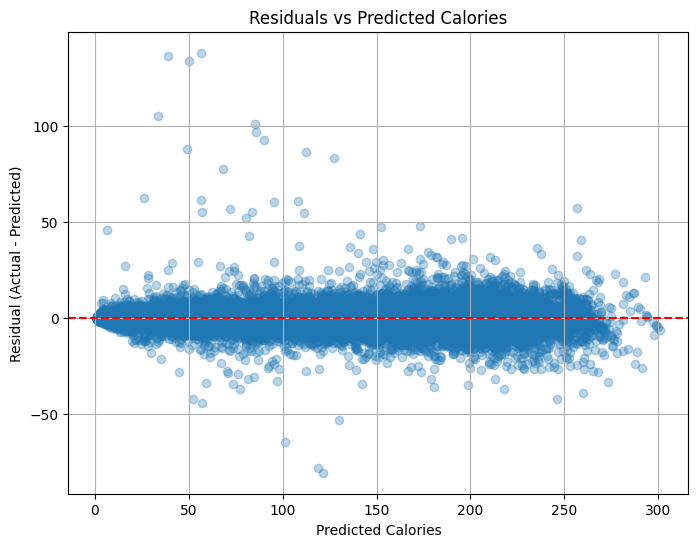

In [26]:
residuals = y_val_real - val_preds_real

plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=100, color='purple', edgecolor='black')
plt.title('Distribution of Residuals (Actual - Predicted)')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Optional: Residual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(val_preds_real, residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Calories')
plt.xlabel('Predicted Calories')
plt.ylabel('Residual (Actual - Predicted)')
plt.grid(True)
plt.show()


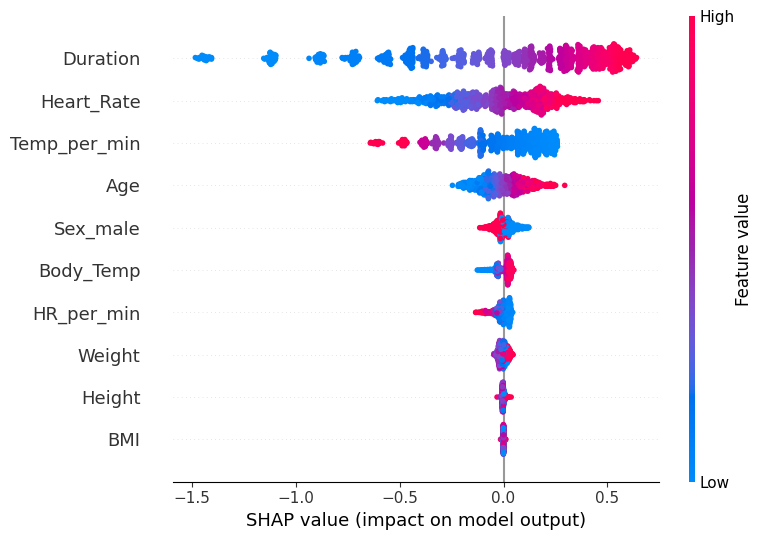

In [28]:
import shap

# TreeExplainer for LGBM
explainer = shap.TreeExplainer(best_lgb_model)
shap_values = explainer.shap_values(X_train[:1000])  # Limit to 1000 rows for speed

# SHAP Summary (Beeswarm)
shap.summary_plot(shap_values, X_train[:1000], plot_type="dot")
